In [ ]:
"""
To make sure the fusion decomposition works
up to the part where we would stitch the sublimbs together into one limb


"""

In [1]:
from os import sys
sys.path.append("/meshAfterParty/")

In [2]:
import skeleton_utils as sk
import soma_extraction_utils as sm
import trimesh_utils as tu
import trimesh
import numpy_utils as nu
import numpy as np
from importlib import reload
import networkx as nx
import time
import compartment_utils as cu
import networkx_utils as xu
import matplotlib_utils as mu
import neuron_utils as nru

#importing at the bottom so don't get any conflicts
import itertools
from tqdm_utils import tqdm

#for meshparty preprocessing
import meshparty_skeletonize as m_sk
import general_utils as gu
import compartment_utils as cu
from meshparty import trimesh_io
from copy import deepcopy


from neuron_utils import *


# Loading the Neuron

In [3]:
import trimesh_utils as tu
curent_neuron = tu.load_mesh_no_processing("/notebooks/test_neurons/Segmentation_2/864691136538557090_long_apical_and_long_axon.off")
segment_id = 864691136739250798
description = "double_soma_inhibit_stretched"

In [4]:
import neuron_visualizations as nviz
nviz.plot_objects(main_mesh=curent_neuron)

/usr/local/lib/python3.6/dist-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float64". A coerced copy has been created.
  np.dtype(self.dtype).name))


# Setting the Arguments that would be present inside a preprocessing function call

In [5]:
#predefined arguments for the Neuron constructor

decomposition_type="meshafterparty"
mesh_correspondence="meshparty" #meshafterparty_adaptive
distance_by_mesh_center=True #how the distance is calculated for mesh correspondence
meshparty_segment_size = 100
meshparty_n_surface_downsampling = 2
meshparty_adaptive_correspondence_after_creation=False
suppress_preprocessing_print=True
computed_attribute_dict=None
somas = None
branch_skeleton_data=None
combine_close_skeleton_nodes = True
combine_close_skeleton_nodes_threshold=700
ignore_warnings=True
suppress_output=False
calculate_spines=True
widths_to_calculate=["no_spine_median_mesh_center",
                "no_spine_mean_mesh_center"]
fill_hole_size=2000

In [6]:
#arguments for the preprocess neuron
mesh = curent_neuron
segment_id=segment_id
description=description

sig_th_initial_split=15 #for significant splitting meshes in the intial mesh split
limb_threshold = 2000 #the mesh faces threshold for a mesh to be qualified as a limb (otherwise too small)
filter_end_node_length=4001 #used in cleaning the skeleton during skeletonizations
return_no_somas = False

decomposition_type=decomposition_type
mesh_correspondence=mesh_correspondence
distance_by_mesh_center=distance_by_mesh_center
meshparty_segment_size =meshparty_segment_size
meshparty_n_surface_downsampling = meshparty_n_surface_downsampling
somas=somas
branch_skeleton_data=branch_skeleton_data
combine_close_skeleton_nodes = combine_close_skeleton_nodes
combine_close_skeleton_nodes_threshold=combine_close_skeleton_nodes_threshold

# Setting up the metadata

In [7]:
whole_processing_tiempo = time.time()


"""
Purpose: To process the mesh into a format that can be loaded into the neuron class
and used for higher order processing (how to visualize is included)

"""
if description is None:
    description = "no_description"
if segment_id is None:
    #pick a random segment id
    segment_id = np.random.randint(100000000)
    print(f"picking a random 7 digit segment id: {segment_id}")
    description += "_random_id"


if mesh is None:
    if current_mesh_file is None:
        raise Exception("No mesh or mesh_file file were given")
    else:
        current_neuron = trimesh.load_mesh(current_mesh_file)
else:
    current_neuron = mesh

# ************************ Phase A: Soma and Limb Identification ********************************

In [8]:
# --- 1) Doing the soma detection
if somas is None:
    soma_mesh_list,run_time,total_soma_list_sdf = sm.extract_soma_center(segment_id,
                                             current_neuron.vertices,
                                             current_neuron.faces)
else:
    soma_mesh_list,run_time,total_soma_list_sdf = somas

# geting the soma centers
if len(soma_mesh_list) <= 0:
    print(f"**** No Somas Found for Mesh {segment_id} so just one mesh")
    soma_mesh_list_centers = []
    if return_no_somas:
        return_value= soma_mesh_list_centers
    raise Exception("Processing of No Somas is not yet implemented yet")
else:
    #compute the soma centers
    print(f"Soma List = {soma_mesh_list}")

    soma_mesh_list_centers = sm.find_soma_centroids(soma_mesh_list)
    print(f"soma_mesh_list_centers = {soma_mesh_list_centers}")

Current Arguments Using (adjusted for decimation):
 large_mesh_threshold= 15000.0 
large_mesh_threshold_inner = 10000.0 
soma_size_threshold = 937.5 
soma_size_threshold_max = 12000.0
outer_decimation_ratio = 0.25
inner_decimation_ratio = 0.25
xvfb-run -n 7627 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/current_running/864691136739250798/neuron_864691136739250798.off -o /notebooks/Platinum_Decomp_Fusion/current_running/864691136739250798/neuron_864691136739250798_decimated.off -s /notebooks/Platinum_Decomp_Fusion/current_running/864691136739250798/decimation_meshlab_25810202.mls
Total found significant pieces before Poisson = [<trimesh.Trimesh(vertices.shape=(201716, 3), faces.shape=(399253, 3))>]
----- working on large mesh #0: <trimesh.Trimesh(vertices.shape=(201716, 3), faces.shape=(399253, 3))>
pre_largest_mesh_path = /notebooks/Platinum_Decomp_Fusion/current_running/864691136739250798/neuron_864691136739250798_decimated_largest_piece.off
xvfb-r

removed temporary input file: /notebooks/Platinum_Decomp_Fusion/current_running/Poisson_temp/neuron_123317.off
removed temporary output file: /notebooks/Platinum_Decomp_Fusion/current_running/Poisson_temp/neuron_123317_poisson.off
mesh.is_watertight = True
/notebooks/Platinum_Decomp_Fusion/current_running/Poisson_temp/poisson_697097.mls is being deleted....
Inside sphere validater: ratio_val = 4.747714955591209
Soma List = [<trimesh.Trimesh(vertices.shape=(6483, 3), faces.shape=(12751, 3))>]
soma_mesh_list_centers = [array([1310664.68255437,  675975.09983033, 1002779.45832176])]


In [9]:
#--- 2) getting the soma submeshes that are connected to each soma and identifiying those that aren't (and eliminating any mesh pieces inside the soma)

main_mesh_total = current_neuron


#finding the mesh pieces that contain the soma
#splitting the current neuron into distinct pieces
split_meshes = tu.split_significant_pieces(
                            main_mesh_total,
                            significance_threshold=sig_th_initial_split,
                            print_flag=False)

print(f"# total split meshes = {len(split_meshes)}")


#returns the index of the split_meshes index that contains each soma    
containing_mesh_indices = sm.find_soma_centroid_containing_meshes(soma_mesh_list,
                                        split_meshes)

# filtering away any of the inside floating pieces: 
non_soma_touching_meshes = [m for i,m in enumerate(split_meshes)
                 if i not in list(containing_mesh_indices.values())]


#Adding the step that will filter away any pieces that are inside the soma
if len(non_soma_touching_meshes) > 0 and len(soma_mesh_list) > 0:
    """
    *** want to save these pieces that are inside of the soma***
    """

    non_soma_touching_meshes,inside_pieces = sm.filter_away_inside_soma_pieces(soma_mesh_list,non_soma_touching_meshes,
                                    significance_threshold=sig_th_initial_split,
                                    return_inside_pieces = True)                                                      


split_meshes # the meshes of the original mesh
containing_mesh_indices #the mapping of each soma centroid to the correct split mesh
soma_containing_meshes = sm.grouping_containing_mesh_indices(containing_mesh_indices)

soma_touching_meshes = [split_meshes[k] for k in soma_containing_meshes.keys()]


#     print(f"# of non soma touching seperate meshes = {len(non_soma_touching_meshes)}")
#     print(f"# of inside pieces = {len(inside_pieces)}")
print(f"# of soma containing seperate meshes = {len(soma_touching_meshes)}")
print(f"meshes with somas = {soma_containing_meshes}")






# total split meshes = 94
There were 93 pieces found after size threshold
# of soma containing seperate meshes = 1
meshes with somas = {0: [0]}


In [10]:
tu = reload(tu)
#--- 3)  Soma Extraction was great (but it wasn't the original soma faces), so now need to get the original soma faces and the original non-soma faces of original pieces

#     sk.graph_skeleton_and_mesh(other_meshes=[soma_meshes])

"""
for each soma touching mesh get the following:
1) original soma meshes
2) significant mesh pieces touching these somas
3) The soma connectivity to each of the significant mesh pieces
-- later will just translate the 


Process: 

1) Final all soma faces (through soma extraction and then soma original faces function)
2) Subtact all soma faces from original mesh
3) Find all significant mesh pieces
4) Backtrack significant mesh pieces to orignal mesh and find connectivity of each to all
   the available somas
Conclusion: Will have connectivity map


"""

soma_touching_mesh_data = dict()

for z,(mesh_idx, soma_idxes) in enumerate(soma_containing_meshes.items()):
    soma_touching_mesh_data[z] = dict()
    print(f"\n\n----Working on soma-containing mesh piece {z}----")

    #1) Final all soma faces (through soma extraction and then soma original faces function)
    current_mesh = split_meshes[mesh_idx]

    current_soma_mesh_list = [soma_mesh_list[k] for k in soma_idxes]

    current_time = time.time()
    mesh_pieces_without_soma = sm.subtract_soma(current_soma_mesh_list,current_mesh,
                                                significance_threshold=250)
    print(f"Total time for Subtract Soam = {time.time() - current_time}")
    current_time = time.time()

    mesh_pieces_without_soma_stacked = tu.combine_meshes(mesh_pieces_without_soma)

    # find the original soma faces of mesh
    soma_faces = tu.original_mesh_faces_map(current_mesh,mesh_pieces_without_soma_stacked,matching=False)
    print(f"Total time for Original_mesh_faces_map for mesh_pieces without soma= {time.time() - current_time}")
    current_time = time.time()
    soma_meshes = current_mesh.submesh([soma_faces],append=True,repair=False)

    # finding the non-soma original faces
    non_soma_faces = tu.original_mesh_faces_map(current_mesh,soma_meshes,matching=False)
    non_soma_stacked_mesh = current_mesh.submesh([non_soma_faces],append=True,repair=False)

    print(f"Total time for Original_mesh_faces_map for somas= {time.time() - current_time}")
    current_time = time.time()

    # 3) Find all significant mesh pieces
    sig_non_soma_pieces,insignificant_limbs = tu.split_significant_pieces(non_soma_stacked_mesh,significance_threshold=limb_threshold,
                                                     return_insignificant_pieces=True)

    print(f"Total time for sig_non_soma_pieces= {time.time() - current_time}")
    current_time = time.time()

    soma_touching_mesh_data[z]["branch_meshes"] = sig_non_soma_pieces

    #4) Backtrack significant mesh pieces to orignal mesh and find connectivity of each to all the available somas
    # get all the seperate mesh faces

    #How to seperate the mesh faces
    seperate_soma_meshes,soma_face_components = tu.split(soma_meshes,only_watertight=False)
    #take the top largest ones depending how many were originally in the soma list
    seperate_soma_meshes = seperate_soma_meshes[:len(soma_mesh_list)]
    soma_face_components = soma_face_components[:len(soma_mesh_list)]

    soma_touching_mesh_data[z]["soma_meshes"] = seperate_soma_meshes

    print(f"Total time for split= {time.time() - current_time}")
    current_time = time.time()



    soma_to_piece_connectivity = dict()
    soma_to_piece_touching_vertices = dict()
    soma_to_piece_touching_vertices_idx = dict()
    limb_root_nodes = dict()
    
    m_vert_graph = tu.mesh_vertex_graph(current_mesh)
    
    for i,curr_soma in enumerate(seperate_soma_meshes):
        (connected_mesh_pieces,
         connected_mesh_pieces_vertices,
         connected_mesh_pieces_vertices_idx) = tu.mesh_pieces_connectivity(
                        main_mesh=current_mesh,
                        central_piece=curr_soma,
                        periphery_pieces = sig_non_soma_pieces,
                        return_vertices = True,
                        return_vertices_idx=True)
        #print(f"soma {i}: connected_mesh_pieces = {connected_mesh_pieces}")
        soma_to_piece_connectivity[i] = connected_mesh_pieces

        soma_to_piece_touching_vertices[i] = dict()
        for piece_index,piece_idx in enumerate(connected_mesh_pieces):
            limb_root_nodes[piece_idx] = connected_mesh_pieces_vertices[piece_index][0]
            
            """ Old way of finding vertex connected components on a mesh without trimesh function
            #find the number of touching groups and save those 
            soma_touching_graph = m_vert_graph.subgraph(connected_mesh_pieces_vertices_idx[piece_index])
            soma_con_comp = [current_mesh.vertices[np.array(list(k)).astype("int")] for k in list(nx.connected_components(soma_touching_graph))]
            soma_to_piece_touching_vertices[i][piece_idx] = soma_con_comp
            """
            
            soma_to_piece_touching_vertices[i][piece_idx] = tu.split_vertex_list_into_connected_components(
                                                vertex_indices_list=connected_mesh_pieces_vertices_idx[piece_index],
                                                mesh=current_mesh, 
                                                vertex_graph=m_vert_graph, 
                                                return_coordinates=True
                                               )
            
            
            
            

#         border_debug = False
#         if border_debug:
#             print(f"soma_to_piece_connectivity = {soma_to_piece_connectivity}")
#             print(f"soma_to_piece_touching_vertices = {soma_to_piece_touching_vertices}")


    print(f"Total time for mesh_pieces_connectivity= {time.time() - current_time}")

    soma_touching_mesh_data[z]["soma_to_piece_connectivity"] = soma_to_piece_connectivity

print(f"# of insignificant_limbs = {len(insignificant_limbs)} with trimesh : {insignificant_limbs}")



# Lets have an alert if there was more than one soma disconnected meshes
if len(soma_touching_mesh_data.keys()) > 1:
    raise Exception("More than 1 disconnected meshes that contain somas")

current_mesh_data = soma_touching_mesh_data
soma_containing_idx = 0

#doing inversion of the connectivity and touching vertices
piece_to_soma_touching_vertices = gu.flip_key_orders_for_dict(soma_to_piece_touching_vertices)


# ****Soma Touching mesh Data has the branches and the connectivity (So this is where you end up skipping if you don't have somas)***



----Working on soma-containing mesh piece 0----

inside Soma subtraction
mesh pieces in subtact soma BEFORE the filtering inside pieces = [<trimesh.Trimesh(vertices.shape=(230382, 3), faces.shape=(460267, 3))>, <trimesh.Trimesh(vertices.shape=(209843, 3), faces.shape=(417896, 3))>, <trimesh.Trimesh(vertices.shape=(93780, 3), faces.shape=(186827, 3))>, <trimesh.Trimesh(vertices.shape=(68017, 3), faces.shape=(135483, 3))>, <trimesh.Trimesh(vertices.shape=(63469, 3), faces.shape=(126357, 3))>, <trimesh.Trimesh(vertices.shape=(42514, 3), faces.shape=(84667, 3))>, <trimesh.Trimesh(vertices.shape=(37809, 3), faces.shape=(75472, 3))>, <trimesh.Trimesh(vertices.shape=(14658, 3), faces.shape=(29152, 3))>, <trimesh.Trimesh(vertices.shape=(12697, 3), faces.shape=(25296, 3))>]
There were 9 pieces found after size threshold
mesh pieces in subtact soma AFTER the filtering inside pieces = [<trimesh.Trimesh(vertices.shape=(230382, 3), faces.shape=(460267, 3))>, <trimesh.Trimesh(vertices.shape=(20984

# Process that will start for each limb

In [26]:
sk = reload(sk)
tu = reload(tu)
cu = reload(cu)
m_sk = reload(m_sk)
pre = reload(pre)
xu = reload(xu)
nu = reload(nu)
gu = reload(gu)


proper_time = time.time()

#The containers that will hold the final data for the preprocessed neuron
limb_correspondence=dict()
limb_network_stating_info = dict()

# ---------- Part A: skeletonization and mesh decomposition --------- #
skeleton_time = time.time()

for curr_limb_idx,limb_mesh_mparty in enumerate(current_mesh_data[0]["branch_meshes"]):
    
    #Arguments to pass to the specific function (when working with a limb)
    soma_touching_vertices_dict = piece_to_soma_touching_vertices[curr_limb_idx]
    
#     if curr_limb_idx != 10:
#         continue
    
    curr_limb_time = time.time()
    print(f"\n\n----- Working on Proper Limb # {curr_limb_idx} ---------")
    

    limb_correspondence_individual,network_starting_info = pre.preprocess_limb(mesh=limb_mesh_mparty,
                   soma_touching_vertices_dict = soma_touching_vertices_dict,
                   return_concept_network = False, 
                   return_concept_network_starting_info=True,
                   width_threshold_MAP=500,
                   size_threshold_MAP=2000,
                   surface_reconstruction_size=1000,  
                    
                   #arguments added from the big preprocessing step                                                            
                   distance_by_mesh_center=distance_by_mesh_center,
                   meshparty_segment_size=meshparty_segment_size,
                   meshparty_n_surface_downsampling = meshparty_n_surface_downsampling,
                                                                               
                   )
    #Storing all of the data to be sent to 
    
    limb_correspondence[curr_limb_idx] = limb_correspondence_individual
    limb_network_stating_info[curr_limb_idx] = network_starting_info
    
#     raise Exception("Done with #10")
    
    
print(f"Total time for Skeletonization and Mesh Correspondence = {time.time() - skeleton_time}")

pre=reload(pre)
neuron=reload(neuron)
nru = reload(nru)
# ---------- Part B: Stitching on floating pieces --------- #
floating_stitching_time = time.time()

limb_correspondence_with_floating_pieces = pre.attach_floating_pieces_to_limb_correspondence(
        limb_correspondence,
        floating_meshes=non_soma_touching_meshes,
        floating_piece_face_threshold = 600,
        max_stitch_distance=8000,
        distance_to_move_point_threshold = 4000,
        verbose = False)



print(f"Total time for stitching floating pieces = {time.time() - floating_stitching_time}")





# ---------- Part C: Computing Concept Networks --------- #
concept_network_time = time.time()

limb_concept_networks=dict()
limb_labels=dict()

for curr_limb_idx,limb_mesh_mparty in enumerate(current_mesh_data[0]["branch_meshes"]):
    limb_to_soma_concept_networks = pre.calculate_limb_concept_networks(limb_correspondence_with_floating_pieces[curr_limb_idx],
                                                                        run_concept_network_checks=True,
                                                                       **limb_network_stating_info[curr_limb_idx])   



    limb_concept_networks[curr_limb_idx] = limb_to_soma_concept_networks
    limb_labels[curr_limb_idx]= "Unlabeled"
    
print(f"Total time for Concept Networks = {time.time() - concept_network_time}")





preprocessed_data= dict(
    soma_meshes = current_mesh_data[0]["soma_meshes"],
    soma_to_piece_connectivity = current_mesh_data[0]["soma_to_piece_connectivity"],
    soma_sdfs = total_soma_list_sdf,
    insignificant_limbs=insignificant_limbs,
    non_soma_touching_meshes=non_soma_touching_meshes,
    inside_pieces=inside_pieces,
    limb_correspondence=limb_correspondence_with_floating_pieces,
    limb_concept_networks=limb_concept_networks,
    limb_network_stating_info=limb_network_stating_info,
    limb_labels=limb_labels,
    limb_meshes=current_mesh_data[0]["branch_meshes"],
    )

    

print(f"Total time for all limb decomps = {time.time() - proper_time}")

#864049.29563888 1004924.982468    884750.28428994

neuron_obj = neuron.Neuron(
                mesh=curent_neuron,
                 segment_id=segment_id,
                 description=description,
                 preprocessed_data=preprocessed_data,
#                  decomposition_type="meshafterparty",
#                  mesh_correspondence="meshparty", #meshafterparty_adaptive
#                  distance_by_mesh_center=True, #how the distance is calculated for mesh correspondence
#                  meshparty_segment_size = 0,
#                  meshparty_n_surface_downsampling = 0,
#                  meshparty_adaptive_correspondence_after_creation=False,
#                 suppress_preprocessing_print=True,
#                  computed_attribute_dict=None,
#                  somas = None,
#                  branch_skeleton_data=None,
#                  combine_close_skeleton_nodes = True,
#                 combine_close_skeleton_nodes_threshold=700,
    
    
                ignore_warnings=True,
                suppress_output=False,
                #calculate_spines=True,
                #widths_to_calculate=["no_spine_median_mesh_center"]
                calculate_spines=False,
                widths_to_calculate=[],
                )



----- Working on Proper Limb # 0 ---------
Time for preparing soma vertices and root: 1.9550323486328125e-05
cc_vertex_thresh = 10


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:12<00:00, 12.34s/it]

Time for 1st pass MP skeletonization: 15.852367162704468
branches_touching_root = [154]
length of Graph = 32873
Working on path [14227. 14239. 14242.]
path_degrees = [3, 2, 3]
Working on path [19100. 19123. 19146. 19166. 19192. 19239. 19287. 19314.]
path_degrees = [3, 2, 2, 2, 2, 2, 2, 3]
Working on path [26769. 26791. 26814. 26833. 26853. 26869. 26889.]
path_degrees = [3, 2, 2, 2, 2, 2, 3]
Working on path [26887. 26892. 26896. 26897. 26894. 26891. 32875.]
path_degrees = [3, 2, 2, 2, 2, 2, 4]
Working on path [27014. 27039. 27070. 27086.]
path_degrees = [3, 2, 2, 4]
Working on path [32877. 27106. 27126. 27145.]
path_degrees = [5, 2, 2, 3]
max(kept_branches_idx) = 154, len(kept_branches_idx) = 149
empty_indices % = 0.0
 conflict_indices % = 0.013790451193492176



AFTER face_lookup_resolved_test



Decomposing first pass: 23.043453454971313
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [817, 685, 1794, 427, 1209, 1106, 8769, 70, 3258, 15021, 11895, 1746, 705, 2910, 2962, 1026, 4716, 1062, 25365, 6918]
mesh_large_connectivity: 0.3145465850830078
Finding MAP candidates connected components: 0.00047016143798828125
len(filtered_pieces) = 3
skeleton_connectivity_MP : 1.2806508541107178
Grouping MP Sublimbs by Graph: 0.24074649810791016
Divinding into MP and MAP pieces: 9.5367431640625e-07
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.002780437469482422
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 3033 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/current_running/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/current_running/temp/None_poisson.off -s /no


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.028933048248291016
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 8.819968700408936
Checking connected components after removing cycles
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.003446340560913086
filter_end_node_length = 4001
Using Distance measure skeletal_distance



Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (52, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
Inside MAP decomposition and curr_limb_endpoints_must_keep was None
skeletonize_and_clean_connected_branch_CGAL: 8.887641191482544
Working on limb correspondence for #0 MAP piece



Total time for decomposition = 0.6631293296813965
mesh_correspondence_first_pass: 0.6631574630737305
Limb decomposed into 3 branches
divided_skeleton_graph_recovered = (52, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (52, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.1343493298746217
 conflict_indices % = 0.06917423259835712



AFTER face_lookup_resolved_test



Total time for MAP sublimb #0 mesh processing = 9.78039288520813
correspondence_1_to_1: 0.22683095932006836
--- Working on MAP piece 1---
MAP Filtering Soma Pieces: 0.008064508438110352
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 7886 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/current_running/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/current_running/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/current_running/temp/poisson_427051.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/current_running/temp/None.off
removed temporary output file: /notebooks/Platinum_Decomp_Fusion/current_running/temp/None_poisson.off
Using the close holes feature
xvfb-run -n 725 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/current_running/temp/neuron_40747.off -o /notebooks/Platinum_Decomp_Fusion/


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.05374741554260254
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 30.01732563972473
Checking connected components after removing cycles
Total time for mesh KDTree = 0.474719762802124
sbv[0].reshape(-1,3) = [[1308404.   680999.8  997230.1]]
closest_sk_pt_coord BEFORE = [1307050.  682305.  996172.]
current_skeleton.shape = (607, 2, 3)
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [1307050.  682305.  996172.]
skipping soma 0 because closest skeleton node was already end node
endpoints_must_keep = {0: array([[1307050.,  682305.,  996172.]])}
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.6982150077819824
filter_end_node_length = 4001
Using Distance measure skeletal_distance
endpoints_must_keep = [[1307050.  682305.  996172.]]
Number o


Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (563, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 31.20539879798889
Working on limb correspondence for #1 MAP piece



Total time for decomposition = 8.43226671218872
mesh_correspondence_first_pass: 8.432302236557007
Limb decomposed into 7 branches
divided_skeleton_graph_recovered = (563, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (563, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (6, 7)
empty_indices % = 0.1358775905086817
 conflict_indices % = 0.019642038800346248



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back



Total time for MAP sublimb #1 mesh processing = 42.33125710487366
correspondence_1_to_1: 2.6855709552764893
--- Working on MAP piece 2---
MAP Filtering Soma Pieces: 0.0018813610076904297
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 6747 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/current_running/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/current_running/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/current_running/temp/poisson_385151.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/current_running/temp/None.off
removed temporary output file: /notebooks/Platinum_Decomp_Fusion/current_running/temp/None_poisson.off
Using the close holes feature
xvfb-run -n 408 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/current_running/temp/neuron_13041.off -o /notebooks/Platinum_Decomp_Fusion


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.021580219268798828
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 6.347573518753052
Checking connected components after removing cycles
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.0016858577728271484
filter_end_node_length = 4001
Using Distance measure skeletal_distance
no small end nodes to get rid of so returning whole skeleton
Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (25, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
Inside MAP decomposition and curr_limb_endpoints_must_keep was None
skeletonize_and_clean_connected_branch_CGAL: 6.371999979019165
Working on limb correspondence for #2 MAP piece



Total time for decomposition = 0.19156455993652344
mesh_correspondence_first_pass: 0.19159841537475586
Limb decomposed into 1 branches
divided_skeleton_graph_recovered = (25, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (25, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (0, 1)
empty_indices % = 0.032639738882088945
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



Total time for MAP sublimb #2 mesh processing = 6.6465959548950195
correspondence_1_to_1: 0.08109140396118164
Total time for MAP sublimb processing 58.75871396064758
---- Working on MP Decomposition #0 ----
MP filtering soma verts: 0.006598711013793945
Do Not Need to Fix MP Decomposition 0 so just continuing
---- Working on MP Decomposition #1 ----
MP filtering soma verts: 0.007070779800415039
Do Not Need to Fix MP Decomposition 1 so just continuing
---- Working on MP Decomposition #2 ----
MP filtering soma verts: 0.0054509639739990234
Do Not Need to Fix MP Decomposition 2 so just continuing
---- Working on MP Decomposition #3 ----
MP filtering soma verts: 0.0014052391052246094
Do Not Need to Fix MP Decomposition 3 so just continuing
---- Working on MP Decomposition #4 ----
MP filtering soma verts: 0.0010380744934082031
Do Not Need to Fix MP Decomposition 4 so just continuing
---- Working on MP Decomposition #5 ----
MP filtering soma verts: 0.0015065670013427734
Do Not Need to Fix MP 




--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.2396045986891587
 conflict_indices % = 0.027291286128720317



AFTER face_lookup_resolved_test



 Finished with (0, 0) 




---- Working on (1, 0) connection-----
winning_vertex = [1324593.98638394  725358.80641972  966438.13595587]
MP_branches_with_stitch_point = [1, 7]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 779.62311452074
MAP_branches_with_stitch_point = [2]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (1092.2571127782614) 
Found winning edge: [9, 10.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (1098.1227280408639) 
Found winning edge: [9, 10.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (3, 4)
empty_indices % = 0.2298634008478568
 conflict_indices % = 0.2158502119642016



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (1, 0) 




---- Working on (2, 0) connection-----
winning_vertex = [1319129.8648849   727907.78765585  959656.76466245]
MP_branches_with_stitch_point = [4, 8]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 2061.1027491179884
MAP_branches_with_stitch_point = [1]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (2121.237541475529) 
Found winning edge: [31, 32.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (2146.2518417292604) 
Found winning edge: [9, 10.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (3, 4)
empty_indices % = 0.06552706552706553
 conflict_indices % = 0.24906282801019644



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (2, 0) 




---- Working on (3, 0) connection-----
winning_vertex = [1321813.72655147  727407.94503036  964518.9972013 ]
MP_branches_with_stitch_point = [5]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 1947.689152173154
MAP_branches_with_stitch_point = [2]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (519.963650355994) 
Found winning edge: [128, 130.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.07812822098536384
 conflict_indices % = 0.06287363430220573



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (3, 0) 




---- Working on (9, 0) connection-----
winning_vertex = [1313047.79970083  731283.42066926  965340.89084003]
MP_branches_with_stitch_point = [1, 5]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 5974.362137002304
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (3972.4147091325644) 
Found winning edge: [127, 128.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (3949.4739055981768) 
Found winning edge: [0, 1.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (3, 4)
empty_indices % = 0.11283154121863799
 conflict_indices % = 0.1221505376344086



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (9, 0) 




---- Working on (10, 0) connection-----
winning_vertex = [1314537.90515787  735312.59224482  962529.07863725]
MP_branches_with_stitch_point = [2]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 3383.8205401177306
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (406.97724791661227) 
Found winning edge: [133, 134.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.07894736842105263
 conflict_indices % = 0.05552631578947369



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (10, 0) 




---- Working on (1, 1) connection-----
winning_vertex = [1320211.0645743   691285.2613796   962893.75016494]
MP_branches_with_stitch_point = [5, 9]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [5]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (874.2912487681252) 
Found winning edge: [9, 10.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (879.3147472178088) 
Found winning edge: [2, 4.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.12473308800145382
 conflict_indices % = 0.03466448593884876



AFTER face_lookup_resolved_test



 Finished with (1, 1) 




---- Working on (4, 1) connection-----
winning_vertex = [1269348.57921167  766668.42291837 1014633.67836381]
MP_branches_with_stitch_point = [0, 1]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [1]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (706.961407612087) 
Found winning edge: [9, 10.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (751.3731473268541) 
Found winning edge: [448, 449.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.15593167215170037
 conflict_indices % = 0.0009402914903620122



AFTER face_lookup_resolved_test



 Finished with (4, 1) 




---- Working on (6, 1) connection-----
winning_vertex = [1284375.25494256  701439.85353221  987960.08205894]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 8912.570123877938
MAP_branches_with_stitch_point = [2]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (434.54171957960415) 
Found winning edge: [0, 1.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.1290983606557377
 conflict_indices % = 0.004339440694310511



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (6, 1) 




---- Working on (7, 1) connection-----
winning_vertex = [1277279.55335551  711385.61577302  978564.34151906]
MP_branches_with_stitch_point = [0, 1]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [2]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (1560.0299343854529) 
Found winning edge: [449, 450.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (1637.545421421784) 
Found winning edge: [757, 758.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.15421021494774206
 conflict_indices % = 0.017100036622813196



AFTER face_lookup_resolved_test



 Finished with (7, 1) 




---- Working on (11, 1) connection-----
winning_vertex = [1306447.90816775  682815.5059974   989488.55884864]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 5988.087678181311
MAP_branches_with_stitch_point = [5]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (447.5701075729766) 
Found winning edge: [1761, 1762.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.11524464213505864
 conflict_indices % = 0.011267139653714665



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (11, 1) 




---- Working on (12, 1) connection-----
winning_vertex = [1276985.41763303  720858.53167671 1010733.51211453]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 43097.156979751344
MAP_branches_with_stitch_point = [1]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (354.20984588591773) 
Found winning edge: [32, 33.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.16002415458937197
 conflict_indices % = 0.004013924410343848



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (12, 1) 




---- Working on (1, 2) connection-----
winning_vertex = [1329634.02250101  728770.27531186  966118.47595266]
MP_branches_with_stitch_point = [6, 10]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (969.1240116258296) 
Found winning edge: [25, 26.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (841.7579179983486) 
Found winning edge: [9, 10.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.09347406881152949
 conflict_indices % = 0.24591494976149397



AFTER face_lookup_resolved_test



 Finished with (1, 2) 




---- Working on (5, 2) connection-----
winning_vertex = [1336764.43890956  733084.43308874  961650.86023626]
MP_branches_with_stitch_point = [6, 8]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (560.8140630289298) 
Found winning edge: [9, 10.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (432.24414085174465) 
Found winning edge: [9, 10.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.36235266658886683
 conflict_indices % = 0.017738359201773836



AFTER face_lookup_resolved_test



 Finished with (5, 2) 




---- Working on (8, 2) connection-----
winning_vertex = [1330438.24998264  730561.61239488  963638.81048034]
MP_branches_with_stitch_point = [4]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 2631.768199710366
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (1204.5256597077457) 
Found winning edge: [131, 132.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.12888167241729248
 conflict_indices % = 0.042013395575400854



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (8, 2) 



Time for decomp of Limb = 152.27521014213562


----- Working on Proper Limb # 1 ---------
Time for preparing soma vertices and root: 5.9604644775390625e-06
cc_vertex_thresh = 10


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:03<00:00,  3.57s/it]

Time for 1st pass MP skeletonization: 5.338138103485107
branches_touching_root = [44]
length of Graph = 16965
Working on path [4933. 4944. 4956. 4966. 4978. 4986. 4995. 5000.]
path_degrees = [3, 2, 2, 2, 2, 2, 2, 3]
max(kept_branches_idx) = 44, len(kept_branches_idx) = 44
empty_indices % = 0.0
 conflict_indices % = 0.004527539741604788



AFTER face_lookup_resolved_test



Decomposing first pass: 12.491676092147827
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [8118, 13536, 5817, 50935, 4259, 28507, 3293, 1048, 2522, 16401, 26461, 4933, 7524, 1052, 20497, 6721, 7596, 9642, 16953]
mesh_large_connectivity: 0.764636754989624
Finding MAP candidates connected components: 0.00023937225341796875
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.44778013229370117
Grouping MP Sublimbs by Graph: 0.0964820384979248
Divinding into MP and MAP pieces: 1.430511474609375e-06
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.01622462272644043
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 2503 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/current_running/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/current_running/temp/None_poisson.off -s


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.0821828842163086
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 37.567089319229126
Checking connected components after removing cycles
Total time for mesh KDTree = 1.4454436302185059
sbv[0].reshape(-1,3) = [[1309308.   663526.5 1003810. ]]
closest_sk_pt_coord BEFORE = [1307920.  663191. 1004030.]
current_skeleton.shape = (1904, 2, 3)
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [1307920.  663191. 1004030.]
skipping soma 0 because closest skeleton node was already end node
endpoints_must_keep = {0: array([[1307920.,  663191., 1004030.]])}
    Total time for Fixing Skeleton Soma Endpoint Extension : 2.1775944232940674
filter_end_node_length = 4001
Using Distance measure skeletal_distance
endpoints_must_keep = [[1307920.  663191. 1004030.]]
Number


Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (1867, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 41.347978830337524
Working on limb correspondence for #0 MAP piece



Total time for decomposition = 30.193559885025024
mesh_correspondence_first_pass: 30.19359064102173
Limb decomposed into 11 branches
divided_skeleton_graph_recovered = (1867, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (1867, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (10, 11)
empty_indices % = 0.11508173780293875
 conflict_indices % = 0.011364841083052394



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back



Total time for MAP sublimb #0 mesh processing = 80.24191451072693
correspondence_1_to_1: 8.68410062789917
Total time for MAP sublimb processing 80.24206471443176
---- Working on MP Decomposition #0 ----
MP filtering soma verts: 0.0012814998626708984
Do Not Need to Fix MP Decomposition 0 so just continuing
---- Working on MP Decomposition #1 ----
MP filtering soma verts: 0.0004496574401855469
Do Not Need to Fix MP Decomposition 1 so just continuing
---- Working on MP Decomposition #2 ----
MP filtering soma verts: 0.0015385150909423828
Do Not Need to Fix MP Decomposition 2 so just continuing
---- Working on MP Decomposition #3 ----
MP filtering soma verts: 0.0012423992156982422
Do Not Need to Fix MP Decomposition 3 so just continuing
---- Working on MP Decomposition #4 ----
MP filtering soma verts: 0.0012431144714355469
Do Not Need to Fix MP Decomposition 4 so just continuing
---- Working on MP Decomposition #5 ----
MP filtering soma verts: 0.0015311241149902344
Do Not Need to Fix MP De




--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (3, 4)
empty_indices % = 0.08530235235628124
 conflict_indices % = 0.007091085119187796



AFTER face_lookup_resolved_test



 Finished with (0, 0) 




---- Working on (1, 0) connection-----
winning_vertex = [1316074.28289239  553221.00336124 1000845.53854556]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 73153.88909567948
MAP_branches_with_stitch_point = [8]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (403.85188813498235) 
Found winning edge: [35, 37.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.10115191968346869
 conflict_indices % = 0.0008877782527208759



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (1, 0) 




---- Working on (2, 0) connection-----
winning_vertex = [1314401.52939108  348194.85839195  958670.41674828]
MP_branches_with_stitch_point = [0, 1]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [10]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (2233.7063050752527) 
Found winning edge: [576, 577.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (2334.2548425518353) 
Found winning edge: [9, 10.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.04119116028033619
 conflict_indices % = 0.016782578341075695



AFTER face_lookup_resolved_test



 Finished with (2, 0) 




---- Working on (3, 0) connection-----
winning_vertex = [1270899.65367526  661141.338903   1047502.14018708]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 39822.93209771739
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (411.5701022725247) 
Found winning edge: [573, 574.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.13244750393553723
 conflict_indices % = 0.0106459617385736



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (3, 0) 




---- Working on (4, 0) connection-----
winning_vertex = [1270055.49060901  661224.7256986  1051491.40068849]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 40383.40299052831
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [204, 214.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.12800914069579608
 conflict_indices % = 0.009455892202828888



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (4, 0) 




---- Working on (5, 0) connection-----
winning_vertex = [1297118.5846485   361809.32078603 1003901.60734746]
MP_branches_with_stitch_point = [2]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 43056.991329956756
MAP_branches_with_stitch_point = [2]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [7, 8.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.10797361873543698
 conflict_indices % = 0.01828521780340429



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (5, 0) 




---- Working on (6, 0) connection-----
winning_vertex = [1327815.67012857  637570.00588465 1015613.72345951]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 21152.15510657831
MAP_branches_with_stitch_point = [9]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (748.4338830573661) 
Found winning edge: [9, 10.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.1844065698432699
 conflict_indices % = 0.0178172734708314



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (6, 0) 




---- Working on (7, 0) connection-----
winning_vertex = [1264359.33535265  669509.23943236 1030857.54343744]
MP_branches_with_stitch_point = [0, 1]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 560.4007494641669
MAP_branches_with_stitch_point = [1]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (796.6569454326922) 
Found winning edge: [964, 965.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (733.6872819326604) 
Found winning edge: [48, 50.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (3, 4)
empty_indices % = 0.14041659053535538
 conflict_indices % = 0.006669102868627809



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (7, 0) 




---- Working on (8, 0) connection-----
winning_vertex = [1256959.3269212   662431.44693185 1088198.96677798]
MP_branches_with_stitch_point = [0, 1]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (561.3239005302289) 
Found winning edge: [404, 405.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (537.6987340845415) 
Found winning edge: [145, 147.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.13932666207511243
 conflict_indices % = 0.018595794676497995



AFTER face_lookup_resolved_test



 Finished with (8, 0) 




---- Working on (9, 0) connection-----
winning_vertex = [1317752.28140974  354352.91079103  968555.28545263]
MP_branches_with_stitch_point = [2]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 10477.795232479139
MAP_branches_with_stitch_point = [10]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (333.533246746509) 
Found winning edge: [9, 10.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.09622693257062258
 conflict_indices % = 0.010147709908709791



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (9, 0) 




---- Working on (10, 0) connection-----
winning_vertex = [1317852.64434641  426067.40092434  999324.69226065]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 22340.22023026407
MAP_branches_with_stitch_point = [11]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [8, 9.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.07782371479887491
 conflict_indices % = 0.001558846453624318



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (10, 0) 




---- Working on (11, 0) connection-----
winning_vertex = [1316302.64013062  563750.85165793 1000571.59016657]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 62693.08369898773
MAP_branches_with_stitch_point = [8]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (546.229585248129) 
Found winning edge: [41, 42.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.132315446190335
 conflict_indices % = 0.0023124814705010378



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (11, 0) 




---- Working on (12, 0) connection-----
winning_vertex = [1272665.39427138  659355.27717492 1032599.94320964]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 24003.458581897557
MAP_branches_with_stitch_point = [12]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (1362.3616157772192) 
Found winning edge: [1122, 1123.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.12616834330828983
 conflict_indices % = 0.015102508595441233



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (12, 0) 




---- Working on (13, 0) connection-----
winning_vertex = [1311219.46999766  631683.01599651 1005286.56205051]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 4581.4704290554
MAP_branches_with_stitch_point = [7]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (471.9780901816264) 
Found winning edge: [9, 10.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.1864702461717387
 conflict_indices % = 0.0077534405892614846



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (13, 0) 



Time for decomp of Limb = 178.1551275253296


----- Working on Proper Limb # 2 ---------
Time for preparing soma vertices and root: 5.7220458984375e-06
cc_vertex_thresh = 10


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

Time for 1st pass MP skeletonization: 1.618177890777588
branches_touching_root = [4]
length of Graph = 6848
max(kept_branches_idx) = 14, len(kept_branches_idx) = 15
empty_indices % = 0.0
 conflict_indices % = 0.004608541591954053



AFTER face_lookup_resolved_test



Decomposing first pass: 8.347480058670044
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [11695, 4112, 2769, 5303, 23287, 14378, 853, 15687]
mesh_large_connectivity: 0.09811091423034668
Finding MAP candidates connected components: 0.000148773193359375
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.19717907905578613
Grouping MP Sublimbs by Graph: 0.04912281036376953
Divinding into MP and MAP pieces: 9.5367431640625e-07
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.005262613296508789
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 4169 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/current_running/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/current_running/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/current_running/temp/poisson_915048.


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.05091595649719238
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 27.613603353500366
Checking connected components after removing cycles
Total time for mesh KDTree = 0.46987009048461914
sbv[0].reshape(-1,3) = [[1303880.   680923.4 1010876. ]]
closest_sk_pt_coord BEFORE = [1303270.  682370. 1011840.]
current_skeleton.shape = (627, 2, 3)
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [1303270.  682370. 1011840.]
skipping soma 0 because closest skeleton node was already end node
endpoints_must_keep = {0: array([[1303270.,  682370., 1011840.]])}
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.690161943435669
filter_end_node_length = 4001
Using Distance measure skeletal_distance
endpoints_must_keep = [[1303270.  682370. 1011840.]]
Number


Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (602, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 28.72996973991394
Working on limb correspondence for #0 MAP piece



Total time for decomposition = 7.988208532333374
mesh_correspondence_first_pass: 7.988243579864502
Limb decomposed into 5 branches
divided_skeleton_graph_recovered = (602, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (602, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (4, 5)
empty_indices % = 0.12740126018134318
 conflict_indices % = 0.013844065365503816



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back



Total time for MAP sublimb #0 mesh processing = 39.4624297618866
correspondence_1_to_1: 2.738914966583252
Total time for MAP sublimb processing 39.46254301071167
---- Working on MP Decomposition #0 ----
MP filtering soma verts: 0.0010638236999511719
Do Not Need to Fix MP Decomposition 0 so just continuing
---- Working on MP Decomposition #1 ----
MP filtering soma verts: 0.0022056102752685547
Do Not Need to Fix MP Decomposition 1 so just continuing
---- Working on MP Decomposition #2 ----
MP filtering soma verts: 0.0018503665924072266
Do Not Need to Fix MP Decomposition 2 so just continuing
---- Working on MP Decomposition #3 ----
MP filtering soma verts: 0.0023849010467529297
Do Not Need to Fix MP Decomposition 3 so just continuing
---- Working on MP Decomposition #4 ----
MP filtering soma verts: 0.0028526782989501953
Do Not Need to Fix MP Decomposition 4 so just continuing

---- Working on (0, 0) connection-----
winning_vertex = [1264926.91814659  715667.86419531 1071920.85304322]
MP




--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.15300978179082017
 conflict_indices % = 0.0008276899924755455



AFTER face_lookup_resolved_test



 Finished with (0, 0) 




---- Working on (1, 0) connection-----
winning_vertex = [1259957.74493722  676180.44616414 1095160.63681681]
MP_branches_with_stitch_point = [0, 1]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 1364.1228851427886
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (2525.7333259074285) 
Found winning edge: [294, 295.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (2513.5106448866727) 
Found winning edge: [265, 266.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (3, 4)
empty_indices % = 0.0920854734810863
 conflict_indices % = 0.02715741082323562



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (1, 0) 




---- Working on (2, 0) connection-----
winning_vertex = [1286650.5511029   720039.02025538 1049260.25106242]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 47479.970354438745
MAP_branches_with_stitch_point = [2]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (850.9249561126161) 
Found winning edge: [781, 782.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.10179365322704277
 conflict_indices % = 0.012781695538862487



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (2, 0) 




---- Working on (3, 0) connection-----
winning_vertex = [1279604.78264366  700953.26742591 1035622.59454135]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 18663.917693268242
MAP_branches_with_stitch_point = [1]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [822, 832.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.1557695401374302
 conflict_indices % = 0.009882104198745202



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (3, 0) 




---- Working on (4, 0) connection-----
winning_vertex = [1293554.11842431  691586.30460913 1019712.11706512]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 2093.5846769063974
MAP_branches_with_stitch_point = [6]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (1424.6964573574562) 
Found winning edge: [1137, 1138.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.1527102187942094
 conflict_indices % = 0.010542431348229686



AFTER face_lookup_resolved_test


  0%|          | 0/1 [00:00<?, ?it/s]


Deleting branches from dictionary
 Finished with (4, 0) 



Time for decomp of Limb = 85.48752689361572


----- Working on Proper Limb # 3 ---------
Time for preparing soma vertices and root: 6.9141387939453125e-06
cc_vertex_thresh = 10


100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

Time for 1st pass MP skeletonization: 1.063943862915039
branches_touching_root = [10]
length of Graph = 5584
max(kept_branches_idx) = 10, len(kept_branches_idx) = 11
empty_indices % = 0.0
 conflict_indices % = 0.0029450189322645644



AFTER face_lookup_resolved_test



Decomposing first pass: 4.365901947021484
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [20235, 1506, 40394, 12477, 2302]
mesh_large_connectivity: 0.05679178237915039
Finding MAP candidates connected components: 0.0001316070556640625
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.1288599967956543
Grouping MP Sublimbs by Graph: 0.027542591094970703
Divinding into MP and MAP pieces: 9.5367431640625e-07
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.005229949951171875
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 2862 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/current_running/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/current_running/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/current_running/temp/poisson_990194.mls
removed tempo


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.05474233627319336
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 26.001230239868164
Checking connected components after removing cycles
Total time for mesh KDTree = 0.46705102920532227
sbv[0].reshape(-1,3) = [[1312255.   670327.1  995779.6]]
closest_sk_pt_coord BEFORE = [1312650.  669882.  995151.]
current_skeleton.shape = (702, 2, 3)
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [1312650.  669882.  995151.]
skipping soma 0 because closest skeleton node was already end node
endpoints_must_keep = {0: array([[1312650.,  669882.,  995151.]])}
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.7012119293212891
filter_end_node_length = 4001
Using Distance measure skeletal_distance
endpoints_must_keep = [[1312650.  669882.  995151.]]
Numbe


Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (670, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 27.18824291229248
Working on limb correspondence for #0 MAP piece



Total time for decomposition = 9.167031288146973
mesh_correspondence_first_pass: 9.167062759399414
Limb decomposed into 5 branches
divided_skeleton_graph_recovered = (670, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (670, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (4, 5)
empty_indices % = 0.11360740567386951
 conflict_indices % = 0.01183139610474036



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back



Total time for MAP sublimb #0 mesh processing = 38.90625476837158
correspondence_1_to_1: 2.545661687850952
Total time for MAP sublimb processing 38.906362533569336
---- Working on MP Decomposition #0 ----
MP filtering soma verts: 0.0012688636779785156
Do Not Need to Fix MP Decomposition 0 so just continuing
---- Working on MP Decomposition #1 ----
MP filtering soma verts: 0.0047321319580078125
Do Not Need to Fix MP Decomposition 1 so just continuing

---- Working on (0, 0) connection-----
winning_vertex = [1275051.38693197  664591.09628249  914385.59261719]
MP_branches_with_stitch_point = [0, 1]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [1]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (1321.2954999572019) 
Found winning edge: [714, 715.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (1251.5587593946718) 
Found winning edge: [9, 




--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.13836460981017792
 conflict_indices % = 0.0008382456330106538



AFTER face_lookup_resolved_test



 Finished with (0, 0) 




---- Working on (1, 0) connection-----
winning_vertex = [1266902.12462462  685690.73764957  974057.26743289]
MP_branches_with_stitch_point = [0, 2]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (850.546228258378) 
Found winning edge: [943, 944.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (775.9473033262084) 
Found winning edge: [301, 302.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.10765916041145399
 conflict_indices % = 0.013413956074506534



AFTER face_lookup_resolved_test


  0%|          | 0/1 [00:00<?, ?it/s]


 Finished with (1, 0) 



Time for decomp of Limb = 58.88739538192749


----- Working on Proper Limb # 4 ---------
Time for preparing soma vertices and root: 8.106231689453125e-06
cc_vertex_thresh = 10


100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

Time for 1st pass MP skeletonization: 0.9536869525909424
branches_touching_root = [2]
length of Graph = 4937
max(kept_branches_idx) = 8, len(kept_branches_idx) = 9
empty_indices % = 0.0
 conflict_indices % = 0.00273827330500091



AFTER face_lookup_resolved_test



Decomposing first pass: 3.0332634449005127
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [33058, 1162, 1900, 32037, 25487, 3468]
mesh_large_connectivity: 0.0891420841217041
Finding MAP candidates connected components: 0.00013685226440429688
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.07742595672607422
Grouping MP Sublimbs by Graph: 0.014046669006347656
Divinding into MP and MAP pieces: 1.430511474609375e-06
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.0069103240966796875
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 5234 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/current_running/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/current_running/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/current_running/temp/poisson_113905.mls
re


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.06486392021179199
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 34.53597712516785
Checking connected components after removing cycles
Total time for mesh KDTree = 0.5835268497467041
sbv[0].reshape(-1,3) = [[1320223.   675783.2  995046.7]]
closest_sk_pt_coord BEFORE = [1320600.  675405.  993674.]
current_skeleton.shape = (849, 2, 3)
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [1320600.  675405.  993674.]
skipping soma 0 because closest skeleton node was already end node
endpoints_must_keep = {0: array([[1320600.,  675405.,  993674.]])}
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.900336742401123
filter_end_node_length = 4001
Using Distance measure skeletal_distance
endpoints_must_keep = [[1320600.  675405.  993674.]]
Number o


Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (807, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 36.209325313568115
Working on limb correspondence for #0 MAP piece



Total time for decomposition = 13.641113996505737
mesh_correspondence_first_pass: 13.641143083572388
Limb decomposed into 5 branches
divided_skeleton_graph_recovered = (807, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (807, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (4, 5)
empty_indices % = 0.12748167064832358
 conflict_indices % = 0.006106351429277535



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back



Total time for MAP sublimb #0 mesh processing = 53.026750564575195
correspondence_1_to_1: 3.1693367958068848
Total time for MAP sublimb processing 53.026870012283325
---- Working on MP Decomposition #0 ----
MP filtering soma verts: 0.003477334976196289
Do Not Need to Fix MP Decomposition 0 so just continuing
---- Working on MP Decomposition #1 ----
MP filtering soma verts: 0.0033223628997802734
Do Not Need to Fix MP Decomposition 1 so just continuing

---- Working on (0, 0) connection-----
winning_vertex = [1316380.61897833  668895.35058606  885852.71220178]
MP_branches_with_stitch_point = [0, 1]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (614.1944563286015) 
Found winning edge: [129, 130.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (644.6420892637091) 
Found winning edge: [9, 1




--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.12422207664592204
 conflict_indices % = 0.0015558467081559122



AFTER face_lookup_resolved_test



 Finished with (0, 0) 




---- Working on (1, 0) connection-----
winning_vertex = [1324196.16879978  672348.38000582  973048.12199708]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 13061.126853261605
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [8, 9.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.11939650921999803
 conflict_indices % = 0.009505965881076817



AFTER face_lookup_resolved_test


  0%|          | 0/1 [00:00<?, ?it/s]


Deleting branches from dictionary
 Finished with (1, 0) 



Time for decomp of Limb = 73.01814246177673


----- Working on Proper Limb # 5 ---------
Time for preparing soma vertices and root: 7.152557373046875e-06
cc_vertex_thresh = 10


100%|██████████| 1/1 [00:00<00:00,  3.82it/s]

Time for 1st pass MP skeletonization: 0.6747355461120605
branches_touching_root = [8]
length of Graph = 3169
Working on path [1284. 1293. 1306. 1316. 1327. 1339. 1347.]
path_degrees = [3, 2, 2, 2, 2, 2, 3]
max(kept_branches_idx) = 8, len(kept_branches_idx) = 8
empty_indices % = 0.0
 conflict_indices % = 0.003485885119406336



AFTER face_lookup_resolved_test



Decomposing first pass: 2.132361650466919
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [5509, 3566, 28096, 25496, 2701]
mesh_large_connectivity: 0.05154228210449219
Finding MAP candidates connected components: 0.0001289844512939453
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.05261349678039551
Grouping MP Sublimbs by Graph: 0.010083436965942383
Divinding into MP and MAP pieces: 9.5367431640625e-07
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.009263277053833008
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 8227 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/current_running/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/current_running/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/current_running/temp/poisson_40657.mls
removed tempor


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.05020761489868164
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 24.833595514297485
Checking connected components after removing cycles
Total time for mesh KDTree = 0.4196746349334717
sbv[0].reshape(-1,3) = [[1313487.   675082.9 1008765. ]]
closest_sk_pt_coord BEFORE = [1314440.  675316. 1009760.]
current_skeleton.shape = (568, 2, 3)
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [1314440.  675316. 1009760.]
skipping soma 0 because closest skeleton node was already end node
endpoints_must_keep = {0: array([[1314440.,  675316., 1009760.]])}
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.6273932456970215
filter_end_node_length = 4001
Using Distance measure skeletal_distance
endpoints_must_keep = [[1314440.  675316. 1009760.]]
Number


Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (530, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 25.894064903259277
Working on limb correspondence for #0 MAP piece



Total time for decomposition = 7.206188678741455
mesh_correspondence_first_pass: 7.206216812133789
Limb decomposed into 5 branches
divided_skeleton_graph_recovered = (530, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (530, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (4, 5)
empty_indices % = 0.17777811773344757
 conflict_indices % = 0.016965487700403868



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back



Total time for MAP sublimb #0 mesh processing = 35.51631283760071
correspondence_1_to_1: 2.4067225456237793
Total time for MAP sublimb processing 35.516414642333984
---- Working on MP Decomposition #0 ----
MP filtering soma verts: 0.0014445781707763672
Do Not Need to Fix MP Decomposition 0 so just continuing

---- Working on (0, 0) connection-----
winning_vertex = [1317346.57750419  660632.8917719  1032525.38077154]
MP_branches_with_stitch_point = [0, 1, 2]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [3]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (654.9153364070232) 
Found winning edge: [269, 271.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (607.7243645251503) 
Found winning edge: [24, 26.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (741.5775475472698) 
Found winning edge: [9




--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (3, 4)
empty_indices % = 0.29627971344838816
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test


  0%|          | 0/1 [00:00<?, ?it/s]


 Finished with (0, 0) 



Time for decomp of Limb = 44.953246116638184


----- Working on Proper Limb # 6 ---------
Time for preparing soma vertices and root: 5.245208740234375e-06
cc_vertex_thresh = 10


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

Time for 1st pass MP skeletonization: 0.945711612701416
branches_touching_root = [5]
length of Graph = 8468
max(kept_branches_idx) = 18, len(kept_branches_idx) = 19
empty_indices % = 0.0
 conflict_indices % = 0.004213483146067416



AFTER face_lookup_resolved_test



Decomposing first pass: 8.348688840866089
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Divinding into MP and MAP pieces: 8.273124694824219e-05
Total time for MAP sublimb processing 3.814697265625e-06
---- Working on MP Decomposition #0 ----
Using Quicker soma_to_piece_touching_vertices because no MAP and only one sublimb_mesh piece 
MP filtering soma verts: 6.103515625e-05
Fixing Possible Soma Extension Branch for Sublimb 0
Total time for mesh KDTree = 0.40389299392700195
sbv[0].reshape(-1,3) = [[1306010.   684232.4 1009037. ]]
closest_sk_pt_coord BEFORE = [1306406.90627062  684678.89673003 1008778.60604736]
current_skeleton.shape = (8467, 2, 3)
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [1306406.90627062  684678.89673003 1008778.60604736]
skipping soma 0 because closest skeleton node was already end node
endpoints_must_keep = {0: array([[1306406.90627062,  6

  0%|          | 0/1 [00:00<?, ?it/s]

MP (because soma touching verts) create_soma_extending_branches: 5.669979095458984
No soma extending branch was added for this sublimb even though it had a soma border (means they already existed)
MP (because soma touching verts) soma extension add: 1.9311904907226562e-05
There were not both MAP and MP pieces so skipping the stitch resolving phase
Time for decomp of Limb = 14.964964628219604


----- Working on Proper Limb # 7 ---------
Time for preparing soma vertices and root: 1.049041748046875e-05
cc_vertex_thresh = 10


100%|██████████| 1/1 [00:00<00:00, 11.07it/s]

Time for 1st pass MP skeletonization: 0.2783019542694092
branches_touching_root = [1]
length of Graph = 1237
max(kept_branches_idx) = 2, len(kept_branches_idx) = 3
empty_indices % = 0.0
 conflict_indices % = 0.0018523600439077936



AFTER face_lookup_resolved_test



Decomposing first pass: 0.6866941452026367
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [24497]
mesh_large_connectivity: 0.0001437664031982422
Finding MAP candidates connected components: 7.677078247070312e-05
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.018326759338378906
Grouping MP Sublimbs by Graph: 0.00394749641418457
Divinding into MP and MAP pieces: 7.152557373046875e-07
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.0016644001007080078
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 407 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/current_running/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/current_running/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/current_running/temp/poisson_619925.mls
removed temporary input file: /no


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.027509450912475586
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 12.932230949401855
Checking connected components after removing cycles
Total time for mesh KDTree = 0.1728663444519043
sbv[0].reshape(-1,3) = [[1311766.   681862.6 1008518. ]]
closest_sk_pt_coord BEFORE = [1311690.  682252. 1008710.]
current_skeleton.shape = (231, 2, 3)
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [1311690.  682252. 1008710.]
skipping soma 0 because closest skeleton node was already end node
endpoints_must_keep = {0: array([[1311690.,  682252., 1008710.]])}
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.25506091117858887
filter_end_node_length = 4001
Using Distance measure skeletal_distance
endpoints_must_keep = [[1311690.  682252. 1008710.]]
Numb


Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (224, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 13.345483303070068
Working on limb correspondence for #0 MAP piece



Total time for decomposition = 1.8411376476287842
mesh_correspondence_first_pass: 1.841200590133667
Limb decomposed into 1 branches
divided_skeleton_graph_recovered = (224, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (224, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (0, 1)
empty_indices % = 0.13634322570110627
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back



Total time for MAP sublimb #0 mesh processing = 15.765049695968628
correspondence_1_to_1: 0.5766537189483643
Total time for MAP sublimb processing 15.76513123512268
---- Working on MP Decomposition #0 ----
MP filtering soma verts: 0.004985332489013672
Do Not Need to Fix MP Decomposition 0 so just continuing

---- Working on (0, 0) connection-----
winning_vertex = [1328062.63359381  706700.41983458 1086792.11433173]
MP_branches_with_stitch_point = [0, 1]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (606.8750584044183) 
Found winning edge: [9, 10.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (751.8686636213588) 
Found winning edge: [180, 181.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.12376509330406148
 conflict_indices % = 0.0027442371020856204



AFTER face_lookup_resolved_test


  0%|          | 0/1 [00:00<?, ?it/s]


 Finished with (0, 0) 



Time for decomp of Limb = 20.782370805740356


----- Working on Proper Limb # 8 ---------
Time for preparing soma vertices and root: 6.9141387939453125e-06
cc_vertex_thresh = 10


100%|██████████| 1/1 [00:00<00:00, 12.71it/s]

Time for 1st pass MP skeletonization: 0.23873162269592285
branches_touching_root = [0]
length of Graph = 1018
max(kept_branches_idx) = 0, len(kept_branches_idx) = 1
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



Decomposing first pass: 0.5876061916351318
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Divinding into MP and MAP pieces: 6.532669067382812e-05
Total time for MAP sublimb processing 2.384185791015625e-06
---- Working on MP Decomposition #0 ----
Using Quicker soma_to_piece_touching_vertices because no MAP and only one sublimb_mesh piece 
MP filtering soma verts: 5.5789947509765625e-05
Fixing Possible Soma Extension Branch for Sublimb 0
Total time for mesh KDTree = 0.12973690032958984
sbv[0].reshape(-1,3) = [[1312601.   683897.2 1002114. ]]
closest_sk_pt_coord BEFORE = [1312570.91783885  683937.68295836 1002522.9360374 ]
current_skeleton.shape = (1017, 2, 3)
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [1312570.91783885  683937.68295836 1002522.9360374 ]
skipping soma 0 because closest skeleton node was already end node
endpoints_must_keep = {0: array([[1312570.9

checking and resolving cycles
No cycles to fix
curr_limb_concept_networks= {0: [<networkx_utils.GraphOrderedEdges object at 0x7fedf173da20>]}
concept_network_dict = {0: [<networkx_utils.GraphOrderedEdges object at 0x7fedf173da20>]}
checking and resolving cycles
No cycles to fix
curr_limb_concept_networks= {0: [<networkx_utils.GraphOrderedEdges object at 0x7fedf173d978>]}
concept_network_dict = {0: [<networkx_utils.GraphOrderedEdges object at 0x7fedf173d978>]}
checking and resolving cycles
No cycles to fix
curr_limb_concept_networks= {0: [<networkx_utils.GraphOrderedEdges object at 0x7fedf173d9b0>]}
concept_network_dict = {0: [<networkx_utils.GraphOrderedEdges object at 0x7fedf173d9b0>]}
checking and resolving cycles
No cycles to fix
curr_limb_concept_networks= {0: [<networkx_utils.GraphOrderedEdges object at 0x7feecee73710>]}
concept_network_dict = {0: [<networkx_utils.GraphOrderedEdges object at 0x7feecee73710>]}
checking and resolving cycles
No cycles to fix
curr_limb_concept_network

In [12]:
import neuron_visualizations as nviz

In [13]:
nviz.visualize_neuron(neuron_obj,
                      visualize_type=["mesh","skeleton"],
                     limb_branch_dict="all")


 Working on visualization type: mesh

 Working on visualization type: skeleton


In [15]:
returned_colors = nviz.visualize_neuron(neuron_obj,
                      visualize_type=["mesh","skeleton"],
                       limb_branch_dict="all",
                      mesh_resolution="limb",
                      skeleton_resolution="limb",
                     return_color_dict=True)


 Working on visualization type: mesh

 Working on visualization type: skeleton


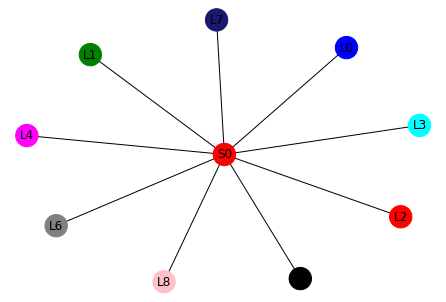

In [18]:
nviz.plot_soma_limb_concept_network(neuron_obj,
                                   node_colors=returned_colors)

In [19]:
returned_colors = nviz.visualize_neuron(neuron_obj,
                      visualize_type=["mesh","skeleton"],
                       limb_branch_dict=dict(L1="all"),
                      mesh_resolution="limb",
                      skeleton_resolution="limb",
                     return_color_dict=True)


 Working on visualization type: mesh

 Working on visualization type: skeleton


# Debugging the Skeleton Dict

In [23]:
sk = reload(sk)

curr_limb_idx = 1
limb_mesh_mparty = current_mesh_data[0]["branch_meshes"][curr_limb_idx]
#Arguments to pass to the specific function (when working with a limb)
soma_touching_vertices_dict = piece_to_soma_touching_vertices[curr_limb_idx]

#     if curr_limb_idx != 10:
#         continue

curr_limb_time = time.time()
print(f"\n\n----- Working on Proper Limb # {curr_limb_idx} ---------")


limb_correspondence_individual,network_starting_info = pre.preprocess_limb(mesh=limb_mesh_mparty,
               soma_touching_vertices_dict = soma_touching_vertices_dict,
               return_concept_network = False, 
               return_concept_network_starting_info=True,
               width_threshold_MAP=500,
               size_threshold_MAP=2000,
               surface_reconstruction_size=1000,  

               #arguments added from the big preprocessing step                                                            
               distance_by_mesh_center=distance_by_mesh_center,
               meshparty_segment_size=meshparty_segment_size,
               meshparty_n_surface_downsampling = meshparty_n_surface_downsampling,

               )



----- Working on Proper Limb # 1 ---------
Time for preparing soma vertices and root: 1.4066696166992188e-05
cc_vertex_thresh = 10


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:03<00:00,  3.55s/it]

Time for 1st pass MP skeletonization: 5.312844276428223
branches_touching_root = [44]
length of Graph = 16965
Working on path [4933. 4944. 4956. 4966. 4978. 4986. 4995. 5000.]
path_degrees = [3, 2, 2, 2, 2, 2, 2, 3]
max(kept_branches_idx) = 44, len(kept_branches_idx) = 44
empty_indices % = 0.0
 conflict_indices % = 0.004527539741604788



AFTER face_lookup_resolved_test



Decomposing first pass: 12.546464204788208
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [8118, 13536, 5818, 50936, 4259, 28507, 3294, 1048, 2523, 16401, 26463, 4932, 7522, 1052, 20498, 6720, 7595, 9641, 16954]
mesh_large_connectivity: 0.767448902130127
Finding MAP candidates connected components: 0.00023245811462402344
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.44644927978515625
Grouping MP Sublimbs by Graph: 0.09656596183776855
Divinding into MP and MAP pieces: 7.152557373046875e-07
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.016367435455322266
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 8384 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/current_running/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/current_running/temp/None_poisson.off 


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.09592652320861816
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 36.747010946273804
Checking connected components after removing cycles
Total time for mesh KDTree = 1.4493608474731445
sbv[0].reshape(-1,3) = [[1309308.   663526.5 1003810. ]]
closest_sk_pt_coord BEFORE = [1307850.  663139. 1004090.]
current_skeleton.shape = (1927, 2, 3)
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [1307850.  663139. 1004090.]
skipping soma 0 because closest skeleton node was already end node
endpoints_must_keep = {0: array([[1307850.,  663139., 1004090.]])}
    Total time for Fixing Skeleton Soma Endpoint Extension : 2.191265821456909
filter_end_node_length = 4001
Using Distance measure skeletal_distance
endpoints_must_keep = [[1307850.  663139. 1004090.]]
Number


Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (1899, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 41.39502143859863
Working on limb correspondence for #0 MAP piece



Total time for decomposition = 30.664865493774414
mesh_correspondence_first_pass: 30.66489315032959
Limb decomposed into 11 branches
divided_skeleton_graph_recovered = (1899, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (1899, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (10, 11)
empty_indices % = 0.10662505247713269
 conflict_indices % = 0.013853963030655126



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back



Total time for MAP sublimb #0 mesh processing = 78.99373483657837
correspondence_1_to_1: 6.917442083358765
Total time for MAP sublimb processing 78.993887424469
---- Working on MP Decomposition #0 ----
MP filtering soma verts: 0.0013892650604248047
Do Not Need to Fix MP Decomposition 0 so just continuing
---- Working on MP Decomposition #1 ----
MP filtering soma verts: 0.0004677772521972656
Do Not Need to Fix MP Decomposition 1 so just continuing
---- Working on MP Decomposition #2 ----
MP filtering soma verts: 0.0014789104461669922
Do Not Need to Fix MP Decomposition 2 so just continuing
---- Working on MP Decomposition #3 ----
MP filtering soma verts: 0.0012328624725341797
Do Not Need to Fix MP Decomposition 3 so just continuing
---- Working on MP Decomposition #4 ----
MP filtering soma verts: 0.0011875629425048828
Do Not Need to Fix MP Decomposition 4 so just continuing
---- Working on MP Decomposition #5 ----
MP filtering soma verts: 0.001463174819946289
Do Not Need to Fix MP Deco




--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (3, 4)
empty_indices % = 0.07661332496600774
 conflict_indices % = 0.008445769270996757



AFTER face_lookup_resolved_test



 Finished with (0, 0) 




---- Working on (1, 0) connection-----
winning_vertex = [1316074.28289239  553221.00336124 1000845.53854556]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 73425.13335982659
MAP_branches_with_stitch_point = [7]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (407.51425310718747) 
Found winning edge: [35, 37.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.09132770529547199
 conflict_indices % = 0.0004604758250191865



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (1, 0) 




---- Working on (2, 0) connection-----
winning_vertex = [1314401.52939108  348194.85839195  958670.41674828]
MP_branches_with_stitch_point = [0, 1]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [10]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (1360.935547664036) 
Found winning edge: [576, 577.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (1475.785929381059) 
Found winning edge: [9, 10.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.036299199914084736
 conflict_indices % = 0.010524620093432852



AFTER face_lookup_resolved_test



 Finished with (2, 0) 




---- Working on (3, 0) connection-----
winning_vertex = [1270899.65367526  661141.338903   1047502.14018708]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 40582.44889489535
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (427.54364627513104) 
Found winning edge: [573, 574.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.13074674461865532
 conflict_indices % = 0.010390645761360617



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (3, 0) 




---- Working on (4, 0) connection-----
winning_vertex = [1270055.49060901  661224.7256986  1051491.40068849]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 39182.29095086213
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [204, 214.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.12847687337483255
 conflict_indices % = 0.00941612166101962



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (4, 0) 




---- Working on (5, 0) connection-----
winning_vertex = [1297118.5846485   361809.32078603 1003901.60734746]
MP_branches_with_stitch_point = [2]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 40783.7161001274
MAP_branches_with_stitch_point = [2]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (1839.7202471993724) 
Found winning edge: [9, 10.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.11228486646884273
 conflict_indices % = 0.011869436201780416



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (5, 0) 




---- Working on (6, 0) connection-----
winning_vertex = [1327815.67012857  637570.00588465 1015613.72345951]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 20673.26937617649
MAP_branches_with_stitch_point = [9]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (649.6294900104721) 
Found winning edge: [9, 10.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.16722220979396435
 conflict_indices % = 0.01478714122726561



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (6, 0) 




---- Working on (7, 0) connection-----
winning_vertex = [1264359.33535265  669509.23943236 1030857.54343744]
MP_branches_with_stitch_point = [0, 1]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 713.0420384316901
MAP_branches_with_stitch_point = [1]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (742.166295659317) 
Found winning edge: [964, 965.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (663.8234850220755) 
Found winning edge: [48, 50.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (3, 4)
empty_indices % = 0.15434901035046306
 conflict_indices % = 0.010380727558864475



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (7, 0) 




---- Working on (8, 0) connection-----
winning_vertex = [1256959.3269212   662431.44693185 1088198.96677798]
MP_branches_with_stitch_point = [0, 1]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = True
Using max stitch distance (300) for smoothing because stitch_distance greater (1445.8276239669535) 
Found winning edge: [404, 405.0]
in remove edge
Using max stitch distance (300) for smoothing because stitch_distance greater (1415.1078769241385) 
Found winning edge: [145, 147.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.1327741987763867
 conflict_indices % = 0.028280863822373485



AFTER face_lookup_resolved_test



 Finished with (8, 0) 




---- Working on (9, 0) connection-----
winning_vertex = [1317752.28140974  354352.91079103  968555.28545263]
MP_branches_with_stitch_point = [2]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 11111.42132893608
MAP_branches_with_stitch_point = [10]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (389.28412143834026) 
Found winning edge: [9, 10.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.07877205968288598
 conflict_indices % = 0.005960497097666446



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (9, 0) 




---- Working on (10, 0) connection-----
winning_vertex = [1317852.64434641  426067.40092434  999324.69226065]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 22031.483470312214
MAP_branches_with_stitch_point = [11]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (335.29758483971165) 
Found winning edge: [9, 10.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.0771044684965901
 conflict_indices % = 0.0015098564788111153



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (10, 0) 




---- Working on (11, 0) connection-----
winning_vertex = [1316302.64013062  563750.85165793 1000571.59016657]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 62736.417198531904
MAP_branches_with_stitch_point = [7]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (611.7990690217547) 
Found winning edge: [41, 42.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.11394391637795742
 conflict_indices % = 0.0050635160344674425



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (11, 0) 




---- Working on (12, 0) connection-----
winning_vertex = [1272665.39427138  659355.27717492 1032599.94320964]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 24690.471361557185
MAP_branches_with_stitch_point = [12]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (1344.5831881779302) 
Found winning edge: [1122, 1123.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.12408962874616185
 conflict_indices % = 0.013830030197680615



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (12, 0) 




---- Working on (13, 0) connection-----
winning_vertex = [1311219.46999766  631683.01599651 1005286.56205051]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 4905.018626654134
MAP_branches_with_stitch_point = [8]
MAP_stitch_point_on_end_or_branch = False
Using max stitch distance (300) for smoothing because stitch_distance greater (414.8886246765474) 
Found winning edge: [9, 10.0]
in remove edge





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.14985590778097982
 conflict_indices % = 0.03631123919308357



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (13, 0) 



Time for decomp of Limb = 177.68716144561768


In [24]:
meshes = [k["branch_mesh"] for k in limb_correspondence_individual.values()]
skeletons = [k["branch_skeleton"] for k in limb_correspondence_individual.values()]
nviz.plot_objects(meshes=meshes,
                 meshes_colors="random",
                 skeletons=skeletons,
                 skeletons_colors="random")

# Sending the data to the Neuron Object

In [ ]:
nru = reload(nru)
save_time = time.time()
neuron_obj.save_compressed_neuron(output_folder="/notebooks/test_neurons/Fusion_decomp/",
                                 export_mesh=True,
                                 suppress_output=True)
print(f"Save time = {time.time() - save_time}")

In [ ]:
nru = reload(nru)
reload_time = time.time()
recovered_neuron = nru.decompress_neuron(filepath="./12345_double_soma",
                     original_mesh="./12345_double_soma")
print(f"Save time = {time.time() - reload_time}")

In [ ]:
import neuron_visualizations as nviz
returned_colors = nviz.visualize_neuron(recovered_neuron,
                     visualize_type=["mesh","skeleton"],
                     limb_branch_dict=dict(L6="all"),
                                       return_color_dict=True)